In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pymc.sampling.jax as pmjax
import jax
import datetime
import argparse
import sys
from matplotlib import rcParams
# Set random seed
RANDOM_SEED = 230810
rng = np.random.default_rng(RANDOM_SEED)

# Set JAX default backend as CPU 
jax.config.update('jax_platform_name', 'cpu')
print(f"JAX default backend: {jax.default_backend()}")

# Ignore Arviz RuntimeWarning when samplin with low number of draws (for testing purposes)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set Arviz plotting options
rc = {
    "plot.max_subplots": 120,
}
az.rcParams.update(rc)

JAX default backend: cpu


In [3]:
data = pd.read_csv("../datasets/model_dataset.csv", index_col=0)
data.head(3)

,edu,edu_level,elementary_edu,highschool_edu,postsec_edu,undergrad_edu,graduate_edu,grad_highschool_refyear,grad_college_refyear,grad_univ_refyear,...,hours_paid,months_last_worked,tenure,sex,age,year,weight,salary,firm_size,loc_size
2,non-university postsecondary certificate,4,1,1,1,0,0,0,0,0,...,2190.0,NaN,55.0,0,26.0,1997,332.9975,78385.474860,1,1
5,graduated high school,3,1,1,0,0,0,0,0,0,...,1955.0,NaN,13.0,0,34.0,1997,317.8111,32225.139665,2,2
8,bachelor's degree,5,1,1,0,1,0,0,0,0,...,2086.0,NaN,138.0,0,34.0,1997,274.8283,62708.379888,3,3


<Axes: xlabel='tenure', ylabel='salary'>

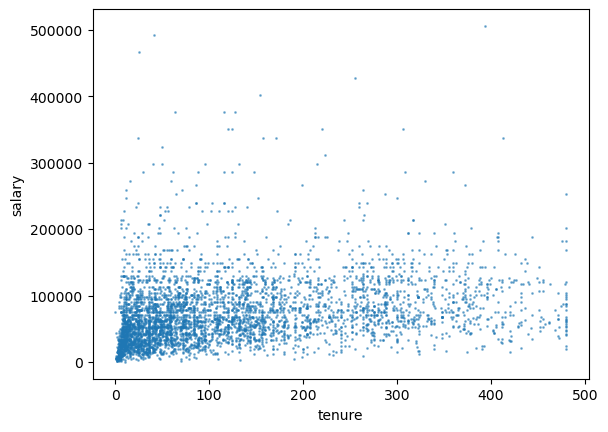

In [4]:
data[data["year"]==2011].plot.scatter(x="tenure", y="salary", s=1, alpha=0.5)

In [5]:
data[data["year"]==2011]["salary"].mean()

73274.5668648056

<Axes: ylabel='Density'>

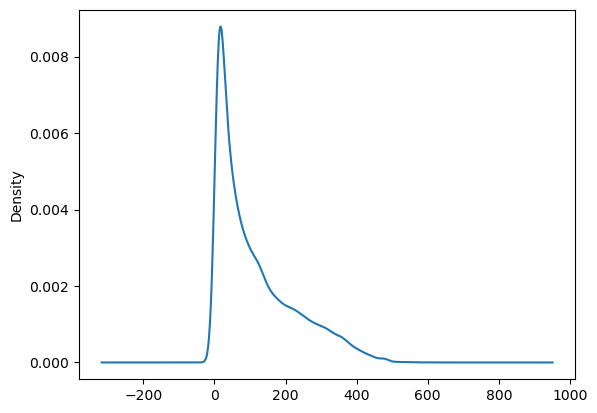

In [6]:
data["tenure"].plot(kind="kde")

In [28]:
year = 2011
ind_idx, industries = pd.factorize(data[data["year"]==year]["industry"])
ten_idx, tenures = pd.factorize(data[data["year"]==year]["tenure"])
salaries = data[data["year"]==year]["salary"].values

coords = {
    "obs": np.arange(len(data[data["year"]==year])),
    "industry": industries
}

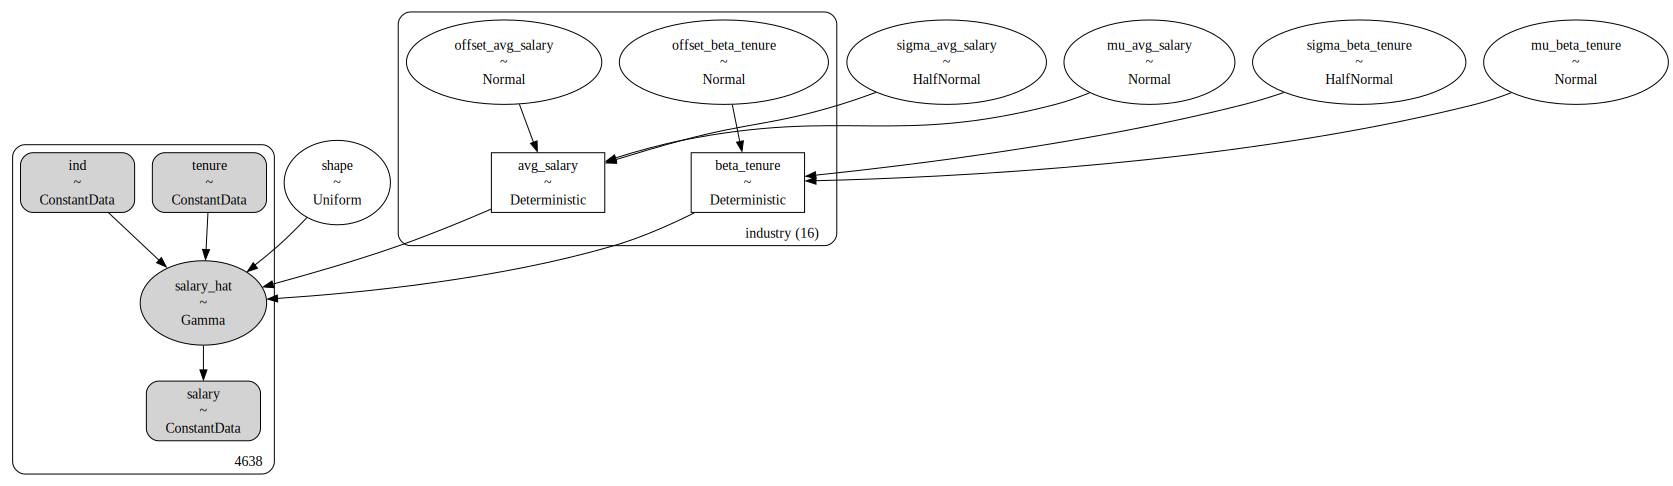

In [36]:

with pm.Model(coords=coords) as test:
    # Data
    ind = pm.Data("ind", ind_idx, mutable=False)
    tenure = pm.Data("tenure", ten_idx, mutable=False)
    salary = pm.Data("salary", salaries, mutable=False)

    # Hyperpriors
    mu_avg_salary = pm.Normal("mu_avg_salary", mu=73000, sigma=10000)
    sigma_avg_salary = pm.HalfNormal("sigma_avg_salary", sigma=10000)
    mu_beta_tenure = pm.Normal("mu_beta_tenure", mu=1000, sigma=1000)
    sigma_beta_tenure = pm.HalfNormal("sigma_beta_tenure", sigma=1000)

    # Priors
    offset_avg_salary = pm.Normal("offset_avg_salary", mu=0, sigma=1, dims="industry")
    avg_salary = pm.Deterministic("avg_salary", mu_avg_salary + offset_avg_salary * sigma_avg_salary, dims="industry")
    offset_beta_tenure = pm.Normal("offset_beta_tenure", mu=0, sigma=1, dims="industry")
    beta_tenure = pm.Deterministic("beta_tenure", mu_beta_tenure + offset_beta_tenure * sigma_beta_tenure, dims="industry")
    # avg_salary = pm.Normal("avg_salary", mu=73000, sigma=10000, dims="industry")
    # beta_tenure = pm.Normal("beta_tenure", mu=1000, sigma=1000, dims="industry")

    # Expected value
    mu = avg_salary[ind] + beta_tenure[ind] * tenure
    # mu = pm.math.exp(ev)

    # Model error
    shape = pm.Uniform("shape", lower=0, upper=100)

    # Likelihood
    y = pm.Gamma("salary_hat", alpha=shape, beta=shape/mu, observed=salary)

    # # Likelihood
    # y = pm.Normal("salary_hat", mu=ev, sigma=100, observed=salary)

pm.model_to_graphviz(test)

In [37]:
with test:
    trace = pmjax.sample_numpyro_nuts(chains=10, draws=5000, tune=5000, target_accept=0.95)

Compiling...
Compilation time =  0:00:06.331517
Sampling...


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Sampling time =  0:03:17.263827
Transforming variables...
Transformation time =  0:00:00.043027


In [38]:
pm.summary(trace, var_names=["~mu_","~offset_","~sigma_"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
shape,2.825,0.056,2.718,2.929,0.000,0.000,79435.0,34560.0,1.0
avg_salary[public administration],87002.465,3623.103,80336.146,93990.734,14.795,10.471,59996.0,44029.0,1.0
avg_salary[transportation and warehousing],61563.651,3304.848,55227.299,67664.257,12.993,9.237,65179.0,43268.0,1.0
avg_salary[health care and social assistance],58941.210,2182.558,54937.846,63146.529,8.646,6.120,63795.0,47326.0,1.0
avg_salary[manufacturing],68972.337,2977.467,63451.361,74554.048,15.502,11.028,36853.0,38965.0,1.0
avg_salary[construction],67177.881,3151.541,61384.514,73240.842,12.696,9.015,62094.0,44020.0,1.0
avg_salary[educational services],73219.088,2917.245,67736.164,78712.115,11.419,8.084,65302.0,45049.0,1.0
avg_salary[trade],47781.807,1768.216,44435.979,51101.485,7.339,5.205,58184.0,45947.0,1.0
"avg_salary[business, building and other support services]",40541.074,2566.306,35802.916,45444.440,10.616,7.536,58549.0,44777.0,1.0
"avg_salary[information, culture and recreation]",68994.405,4119.787,61224.992,76795.431,16.116,11.446,65552.0,43463.0,1.0


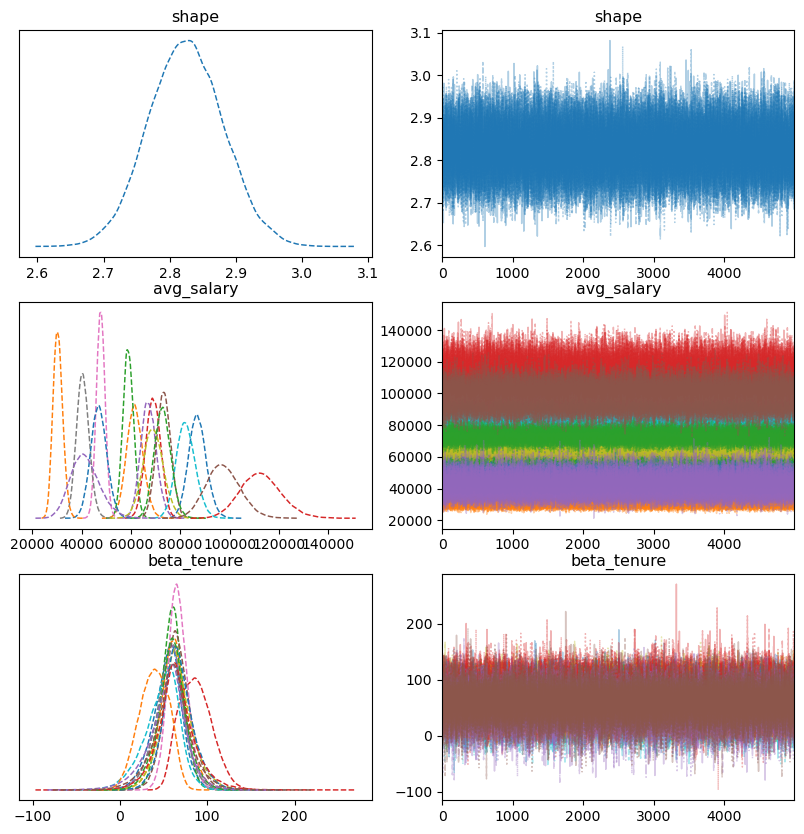

In [39]:
az.plot_trace(trace, var_names=["~mu_","~offset_","~sigma_"], filter_vars="like", combined=True, figsize=(10, 10));

In [7]:
# Ignore Arviz RuntimeWarning when samplin with low number of draws (for testing purposes)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

N = 10000
shape_true = 1.4
scale_true = 60
x = np.random.gamma(shape_true,scale_true,N)
a_true = 30000
b_true = 1000
ev_true = a_true+b_true*x
# y_true = 1 / ev_true

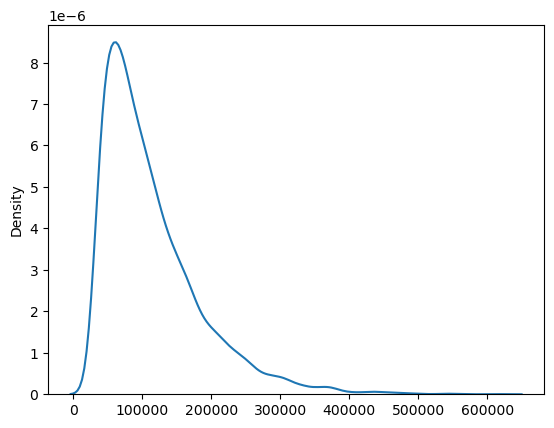

In [9]:
sns.kdeplot(ev_true);

In [10]:
sns.kdeplot(y_true);

NameError: name 'y_true' is not defined

In [11]:
shape_true = 10
with pm.Model() as model2:
    g = pm.Gamma('g', alpha=shape_true, beta=shape_true/ev_true, shape=N)    
y = pm.draw(g)


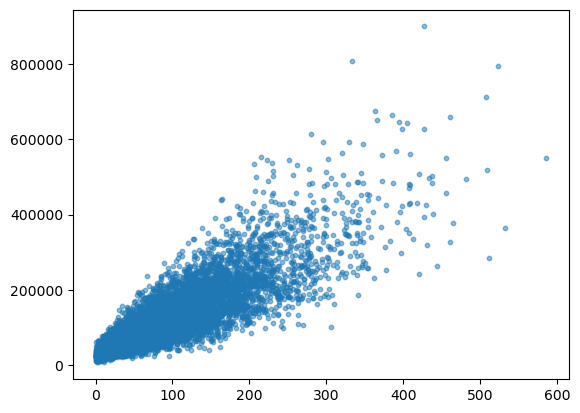

In [12]:
plt.scatter(x, y, s=10, alpha=0.5)

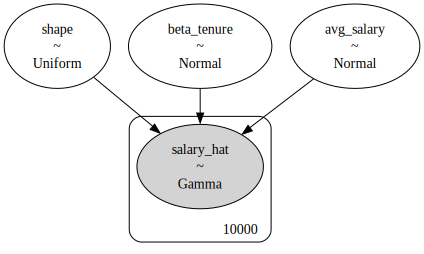

In [13]:
with pm.Model() as test:
    # Priors
    avg_salary = pm.Normal("avg_salary", mu=0, sigma=0.5)
    beta_tenure = pm.Normal("beta_tenure", mu=0, sigma=0.5)

    # Expected value
    ev = avg_salary + beta_tenure * x
    # mu = pm.math.exp(ev)

    # Model error
    shape = pm.Uniform("shape", lower=0, upper=50)

    # Likelihood
    likelihood = pm.Gamma("salary_hat", mu=ev, sigma=shape, observed=y)

pm.model_to_graphviz(test)

In [14]:
with test:
    trace = pmjax.sample_numpyro_nuts(chains=4, tune=1000, target_accept=0.95)
    # trace = pm.sample()

Compiling...
Compilation time =  0:00:04.363220
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:10:57.188326
Transforming variables...
Transformation time =  0:00:00.052304


In [532]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,30000.001,0.498,29999.101,30000.961,0.006,0.005,5970.0,3299.0,1.0
b,1000.006,0.495,999.067,1000.910,0.006,0.005,5810.0,3047.0,1.0
shape,9.894,0.141,9.628,10.153,0.002,0.001,6174.0,3133.0,1.0


In [198]:
np.exp(-1.738)

0.17587179269317635

In [199]:
np.exp(0.349)

1.417649190341986

In [200]:
np.mean(ev_true)

55003.17157224039

In [201]:
np.std(ev_true)

2880.6031222411107

In [202]:
(0.17587179269317635 + 1.417649190341986) * 2880.6031222411107 + 55003.17157224039

59593.473091328204

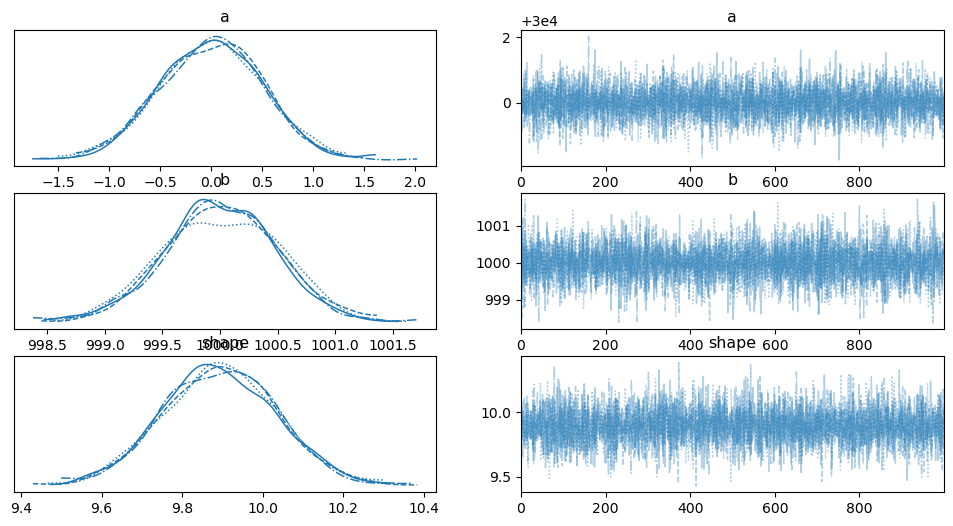

In [531]:
az.plot_trace(trace, compact=True);

In [57]:
import numpy as np
import statsmodels.api as sm

# Step 1: Define Parameters
k = 2  # Shape parameter
theta = 1  # Scale parameter

# Step 2: Generate Predictor Data
np.random.seed(42)  # For reproducibility
num_samples = 10000
X = np.random.uniform(0, 10, num_samples)

# Step 3: Calculate Linear Predictors
intercept = 1
coefficient = 0.5
linear_predictors = intercept + coefficient * X

# Step 4: Generate Gamma-Distributed Response Data
mu = np.exp(linear_predictors)
phi = k / theta
Y = np.random.gamma(mu / phi, scale=phi)

# Step 5: Add Noise (Optional)
noise_stddev = 0.2
Y += np.random.normal(0, noise_stddev, num_samples)

# # Step 6: Fit GLM
# X = sm.add_constant(X)  # Adding constant for intercept
# gamma_glm = sm.GLM(Y, X, family=sm.families.Gamma(link=sm.families.links.log()))
# result = gamma_glm.fit()

# print(result.summary())

# Step 7: Evaluate Results
# Compare the estimated coefficients and other statistics with the true values used in simulation.


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                         0.14095
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 31 Aug 2023   Deviance:                       1856.6
Time:                        12:19:10   Pearson chi2:                 1.41e+03
No. Iterations:                     9   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0219      0.007    136.923      0.0

/home/avena/miniconda3/envs/pymc_env/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [48]:
np.exp(-1)

0.3678794411714424

In [316]:
from scipy.stats import gamma

# Fit gamma distribution to salary data
shape, loc, scale = gamma.fit(data["tenure"])

# Print shape and scale parameters
print("Shape parameter:", shape)
print("Scale parameter:", scale)

Shape parameter: 0.9789929310059973
Scale parameter: 116.0858472971019


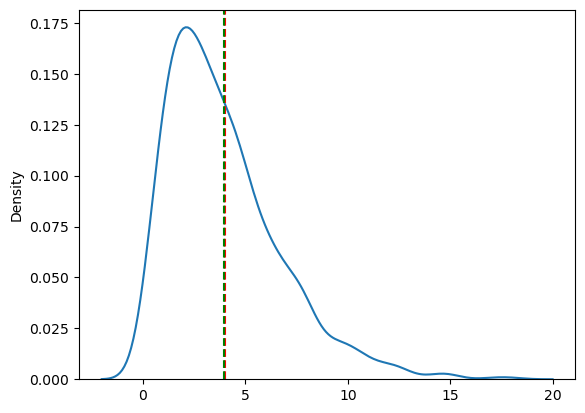

In [323]:
# plot a gamma dist with shape 2 and scale 2
x = np.random.gamma(2, 2, 1000)
sns.kdeplot(x);

# Add a vertical line at the mean
plt.axvline(x=2*2, color="red", linestyle="--");
plt.axvline(x=x.mean(), color="green", linestyle="--");

In [324]:
0.9789929310059973 * 116.0858472971019

113.64722389370442

113.64722389370442


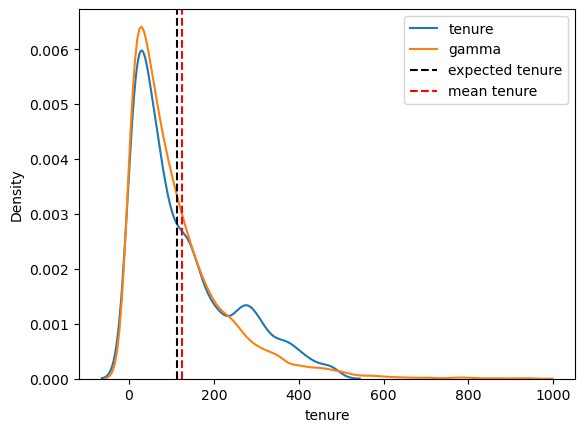

In [326]:
sns.kdeplot(data[data["year"]==2011]["tenure"], label="tenure");
sns.kdeplot(np.random.gamma(0.97,116,N), label="gamma");

print(0.9789929310059973 * 116.0858472971019)

# Add vertical line for expected value of tenure
plt.axvline(0.9789929310059973 * 116.0858472971019, color="black", linestyle="--", label="expected tenure")
plt.axvline(data[data["year"]==2011]["tenure"].mean(), color="red", linestyle="--", label="mean tenure")
plt.legend();

In [372]:
N = 10000
x = np.random.gamma(0.97,116,N)
a_true =37000
b_true = 100
y_true = a_true+b_true*x
# shape_true = 2
# with pm.Model() as model2:
#     g = pm.Gamma('g', alpha=shape_true, beta=shape_true/y_true, shape=N)    
# y = pm.draw(g)

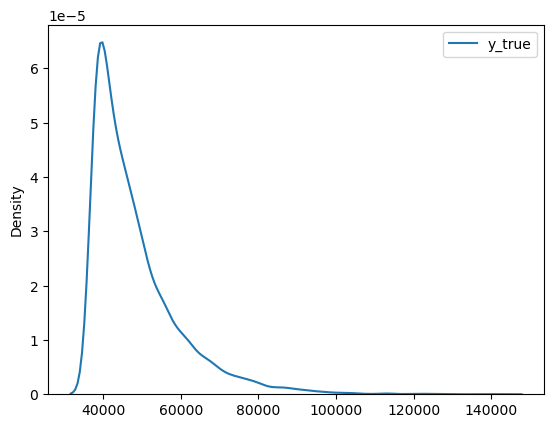

In [373]:
sns.kdeplot(y_true, label="y_true");
# sns.kdeplot(y, label="y");
plt.legend();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


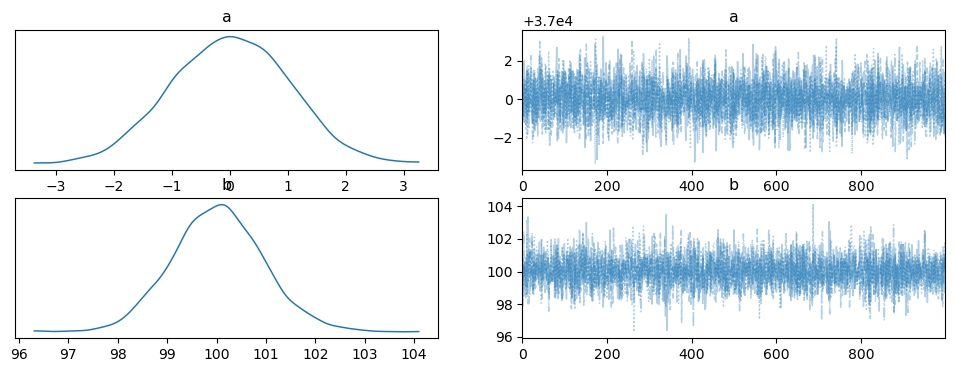

In [375]:
# Model
with pm.Model() as linear_model:
    a = pm.Normal('a', mu=37000, sigma=1)
    b = pm.Normal('b', mu=100, sigma=1)
    # shape = pm.Uniform('shape', lower=0, upper=100)
    
    y_est = a + b * x

    likelihood = pm.Gamma('likelihood', alpha=2, beta=2/y_est, observed=y_true)

# Inference
with linear_model:
    trace = pm.sample()

# Posterior distribution
az.plot_trace(trace, combined=True);

In [377]:
with linear_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["a", "b", "likelihood"])

Sampling: [a, b, likelihood]


<Axes: xlabel='likelihood / likelihood'>

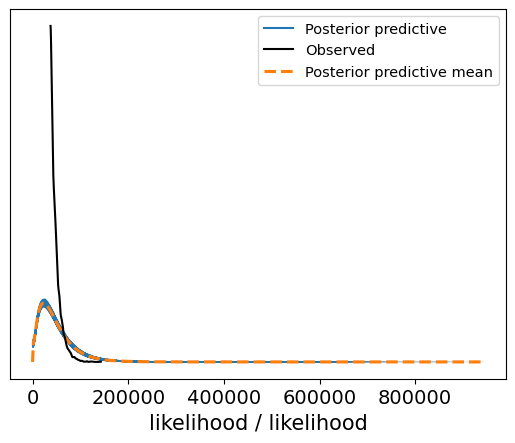

In [378]:
az.plot_ppc(ppc)

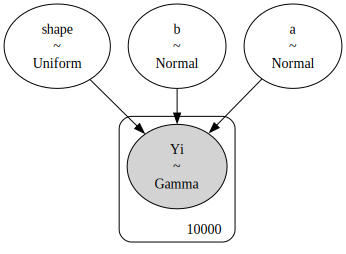

In [65]:
with pm.Model() as Model_1:
    # Priors
    α = pm.Normal('a', 0, 0.5)
    β = pm.Normal('b', 0, 0.5)
    shape = pm.Uniform('shape', 0, 50)

    # Model
    μ = pm.math.exp(α+β*x)

    # Likelihood
    Yi = pm.Gamma('Yi', alpha=shape, beta=shape/μ, observed=y)

pm.model_to_graphviz(Model_1)

In [66]:
with Model_1:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, shape]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [67]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.997,0.003,4.991,5.003,0.000,0.000,6053.0,3310.0,1.0
b,10.004,0.005,9.994,10.014,0.000,0.000,6102.0,3461.0,1.0
shape,9.887,0.141,9.618,10.143,0.002,0.001,6662.0,3366.0,1.0


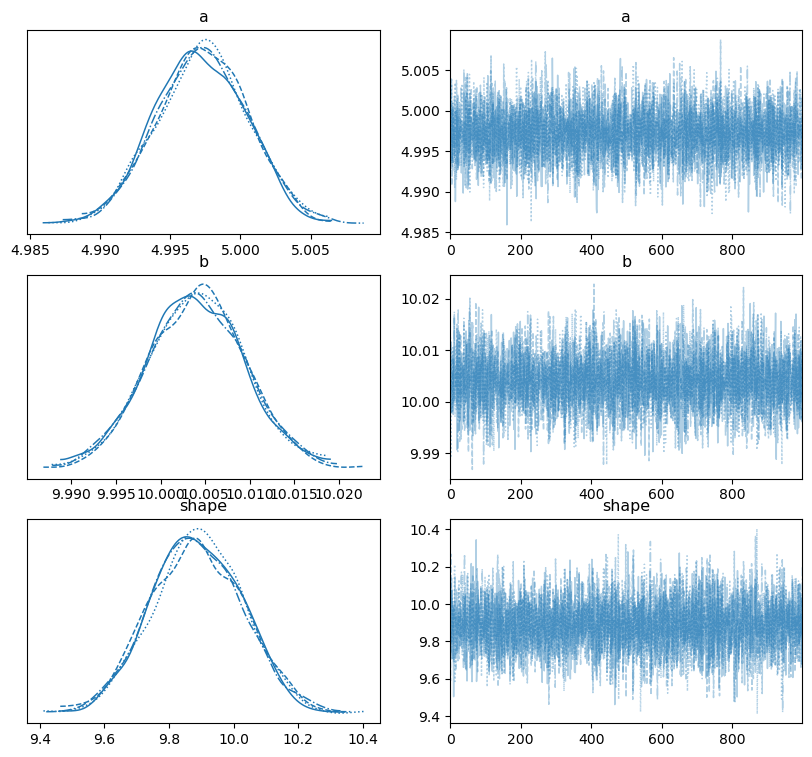

In [68]:
az.plot_trace(trace, figsize=(10,9));

In [384]:
np.exp(8.8118)

6712.9917837041885

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

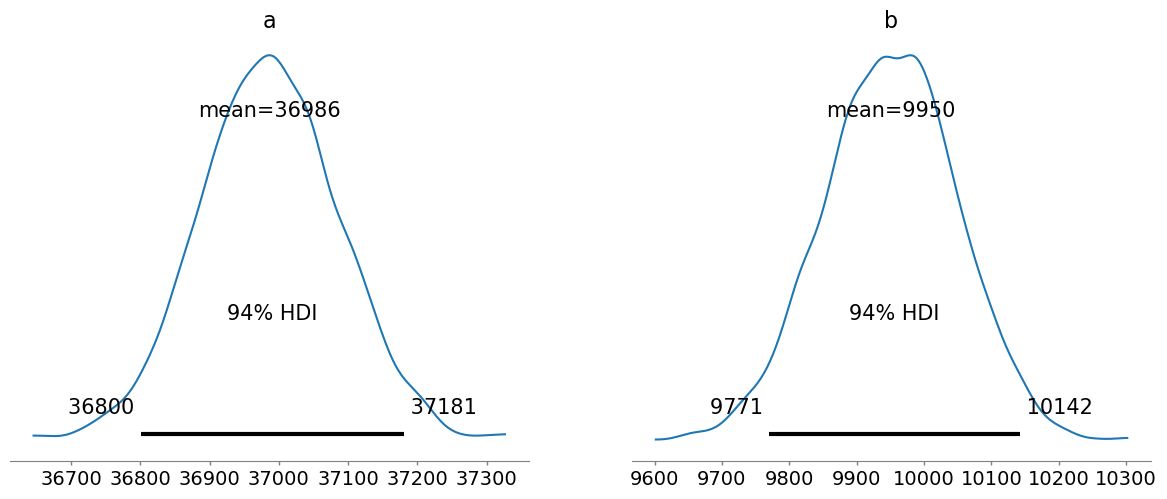

In [536]:
# Simulated data
np.random.seed(42)
x = np.random.uniform(0, 10, size=100)
true_a = 37000
true_b = 10000
true_y = true_a + true_b * x
data = np.random.gamma(shape=2, scale=2/true_y)  # Using the shape-rate parameterization

# Model with log-link function
with pm.Model() as log_linear_model:
    a = pm.Normal('a', mu=37000, sigma=100)
    b = pm.Normal('b', mu=10000, sigma=100)
    
    linear_term = a + b * x
    y_est = linear_term
    
    likelihood = pm.Gamma('likelihood', beta=2, alpha=2/y_est, observed=data)

# Inference
with log_linear_model:
    trace = pm.sample(2000, tune=1000, cores=1)

# Posterior distribution
pm.plot_posterior(trace, var_names=['a', 'b'])


In [406]:

N = 10000
x = np.random.uniform(0,1,N)
a_true = 30000
b_true = 1000
y_true = a_true + b_true * x
shape_true = 10
with pm.Model() as model2:
    g = pm.Gamma('g', alpha=shape_true, beta=shape_true/y_true, shape=N)    
y = pm.draw(g)

In [407]:
with pm.Model() as Model_1:
    # Priors
    α = pm.Normal('a', 30000, 0.5)
    β = pm.Normal('b', 1000, 0.5)
    shape = pm.Uniform('shape', 0, 50)

    # Model
    μ = α+β*x

    # Likelihood
    Yi = pm.Gamma('Yi', alpha=shape, beta=shape/μ, observed=y)

In [408]:
with Model_1:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, shape]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [455]:
for axis in ax:
    print(type(axis[1]))

<class 'matplotlib.axes._axes.Axes'>
<class 'matplotlib.axes._axes.Axes'>
<class 'matplotlib.axes._axes.Axes'>


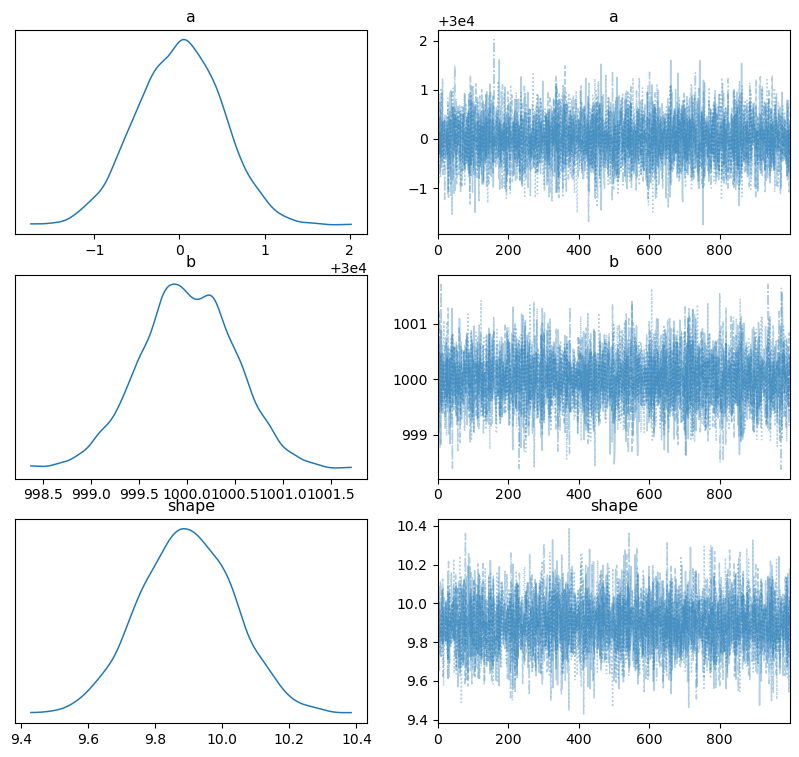

In [456]:
ax = az.plot_trace(trace, figsize=(10,9), combined=True, show=False);
                # plot_kwargs={"ticklabel_format": {"style":"plain"}});


for axis in ax:
    axis[1]

<Axes: title={'center': 'a'}>